In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "data/data"

DATA_ROOT = Path(data_path)




In [3]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

def normalize_eeg(x: np.ndarray) -> np.ndarray:
    """
    Normalize EEG signal between -1 and 1 per channel.

    Parameters:
    - x: EEG signal, shape (time, channels)

    Returns:
    - Normalized signal
    """
    min_vals = x.min(axis=0)
    max_vals = x.max(axis=0)
    return 2 * (x - min_vals) / (max_vals - min_vals + 1e-8) - 1 

from scipy.signal import hilbert
import numpy as np
from scipy.signal import resample

def downsample(x: np.ndarray) -> np.ndarray:
    
    
    # Resample the analytic signal to 300 samples
    downsampled_signal = resample(x, 300, axis=0)
    
    return downsampled_signal


In [4]:

data_root = Path(data_path)
clips_tr = pd.read_parquet(data_root / "train/segments.parquet")
ids = clips_tr["signals_path"].astype(str).tolist()
ids = list(map(lambda x: x[x.find("_") + 1 : x.find("_") + 5], ids))
clips_tr["subject_id"] = ids
clips_tr.head()
# calulate ratio bewteen label 0 and label 1 per unique subject
ratio = clips_tr.groupby("subject_id")["label"].value_counts(normalize=True).unstack()
print(ratio)
# print subject ids 
unique_subjects = clips_tr["subject_id"].unique()
print(unique_subjects)
# print number of clips per subject
print(clips_tr["subject_id"].value_counts())
# print the percentage of clips per subject
print(clips_tr["subject_id"].value_counts(normalize=True))
        

label              0         1
subject_id                    
s001        0.757630  0.242370
s002        0.831869  0.168131
s003        0.840773  0.159227
s004        0.810518  0.189482
s005        0.919028  0.080972
s006        0.837209  0.162791
s007        0.973913  0.026087
s008        0.854167  0.145833
s009        0.758929  0.241071
s010        0.811765  0.188235
s011        0.960784  0.039216
s015             NaN  1.000000
['s001' 's002' 's003' 's005' 's004' 's009' 's011' 's015' 's010' 's008'
 's006' 's007']
subject_id
s001    5046
s002    2504
s003    2173
s004    1198
s005     741
s006     430
s009     224
s008     192
s010     170
s011     153
s007     115
s015      47
Name: count, dtype: int64
subject_id
s001    0.388363
s002    0.192719
s003    0.167244
s004    0.092203
s005    0.057031
s006    0.033095
s009    0.017240
s008    0.014777
s010    0.013084
s011    0.011776
s007    0.008851
s015    0.003617
Name: proportion, dtype: float64


In [5]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    #signal_transform=downsample,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)


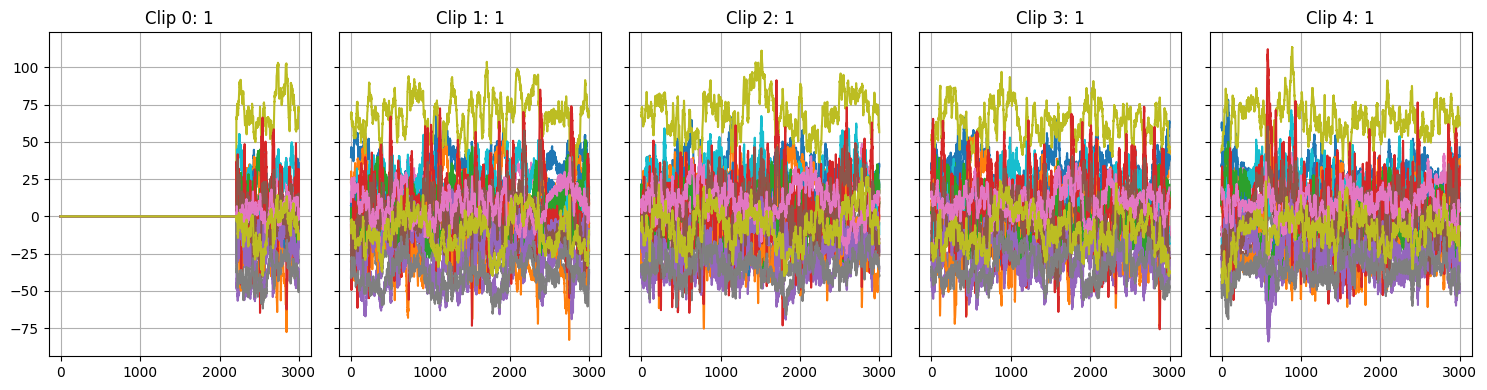

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()


In [7]:
# print the shape of the dataset
print(f"Dataset shape: {dataset_tr.__len__()}")
# print the shape of the first 10 clips
for i in range(10):
    x, y = dataset_tr[i]
    print(f"Clip {i} shape: {x.shape}, label: {y}")

Dataset shape: 12993
Clip 0 shape: (3000, 19), label: 1
Clip 1 shape: (3000, 19), label: 1
Clip 2 shape: (3000, 19), label: 1
Clip 3 shape: (3000, 19), label: 1
Clip 4 shape: (3000, 19), label: 1
Clip 5 shape: (3000, 19), label: 1
Clip 6 shape: (3000, 19), label: 1
Clip 7 shape: (3000, 19), label: 1
Clip 8 shape: (3000, 19), label: 1
Clip 9 shape: (3000, 19), label: 1


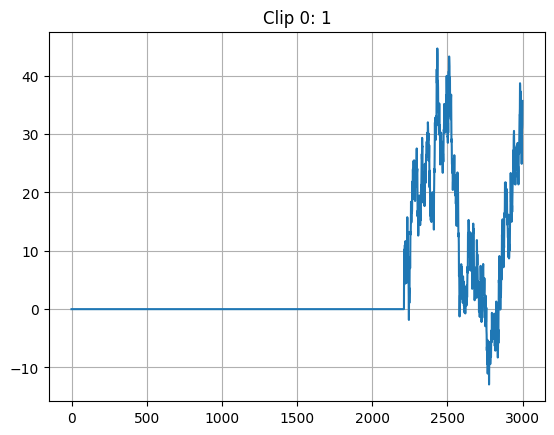

In [8]:
clip, y = dataset_tr[0]
#plot first channel
plt.plot(clip[:, 0])
plt.title(f"Clip 0: {y}")
plt.grid()
plt.show()


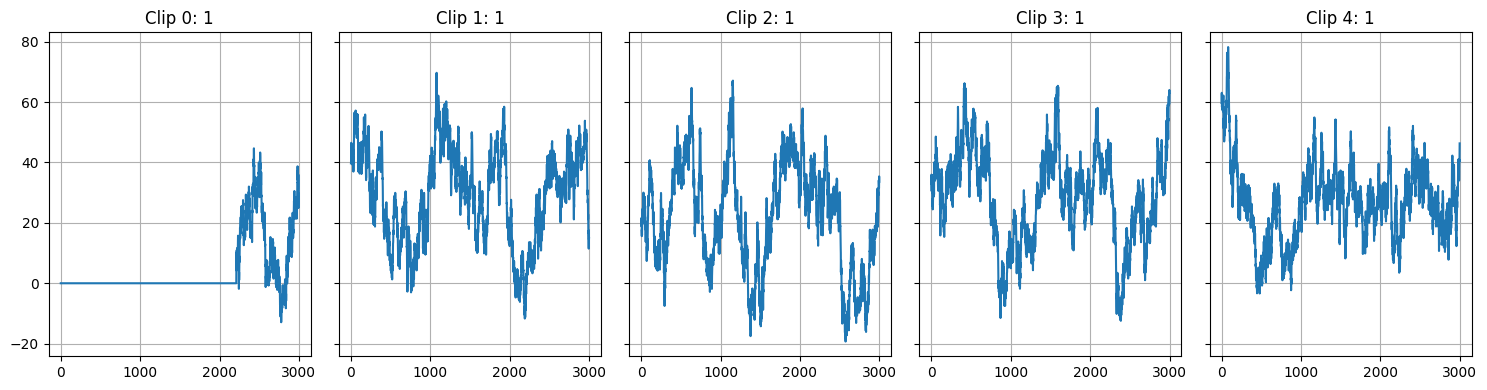

In [9]:
x = []
labels = []
for i in range(len(dataset_tr)):
    clip, y = dataset_tr[i]
    x.append(clip[:, 0])
    labels.append(y)
x = np.array(x)
labels = np.array(labels)
# plot first 5 clips
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

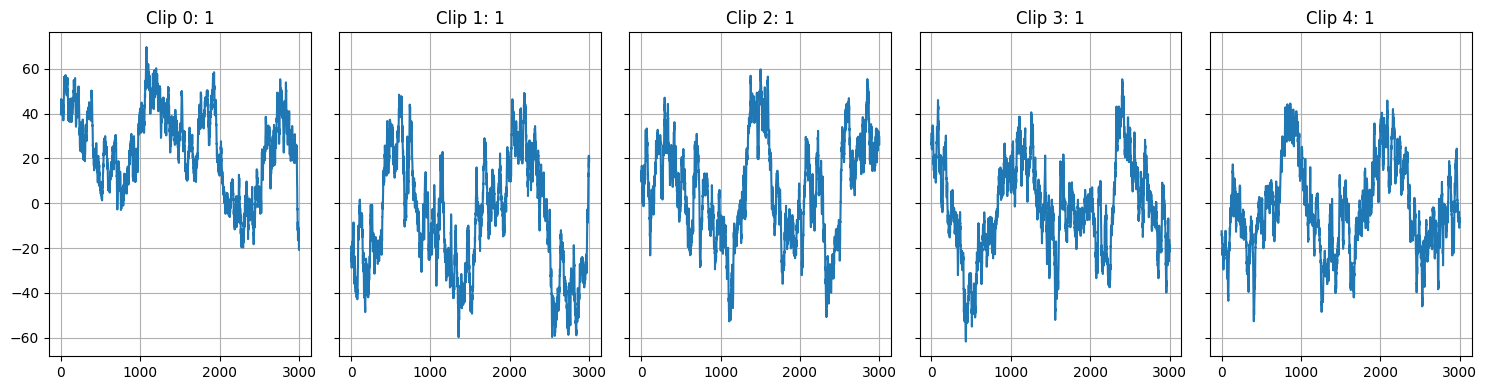

In [10]:
# compute diff of t and t + 1 of data
signals = x
x = np.diff(x, axis=0)
# plot first 5 clips
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

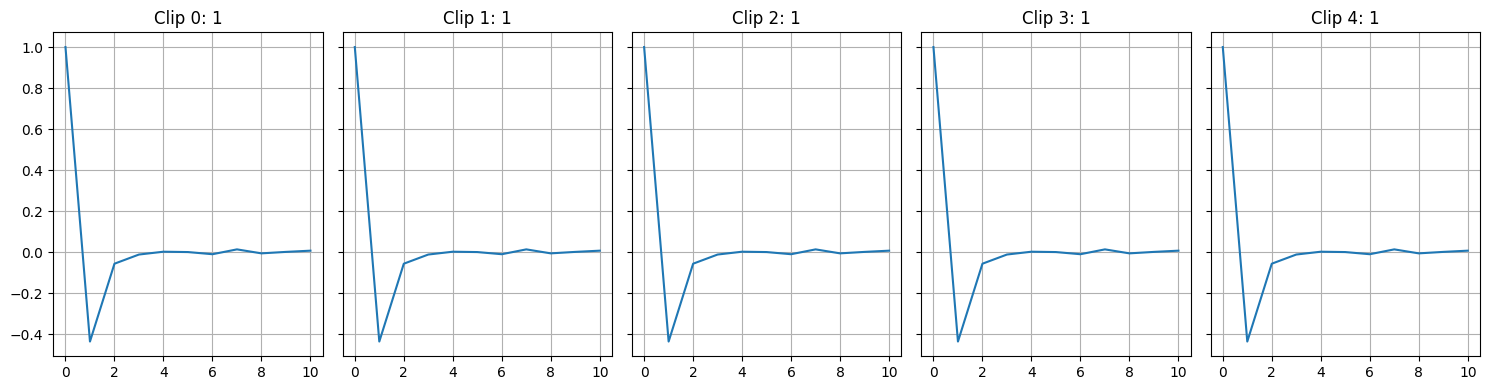

In [11]:
# compute acf of each data and compute mean
from statsmodels.tsa.stattools import acf
def compute_acf(x: np.ndarray, lags: int = 100) -> np.ndarray:
    """
    Compute the autocorrelation function (ACF) of a signal.

    Parameters:
    - x: Input signal, shape (time, channels)
    - lags: Number of lags to compute

    Returns:
    - ACF values for each channel
    """
    acf_values = []
    for i in range(x.shape[1]):
        acf_values.append(acf(x[:, i], nlags=lags))
    mean_acf = np.mean(acf_values, axis=0)
    return mean_acf
lags = 10
mean_acf = compute_acf(x, lags=lags)
# plot acf
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(mean_acf)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()


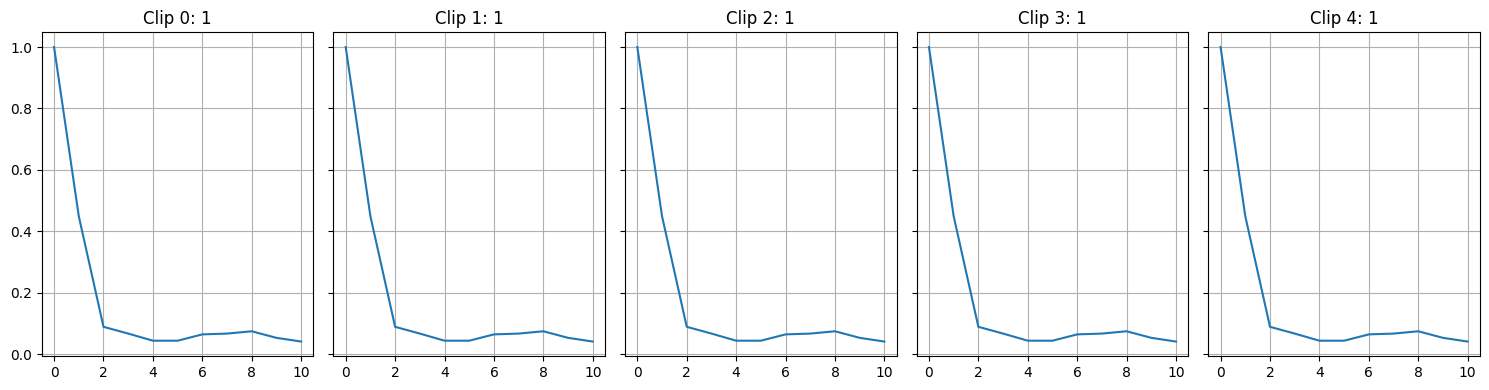

In [12]:
# compute acf volatility
x_squared = x ** 2
mean_acf_squared = compute_acf(x_squared, lags=lags)
# plot acf
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(mean_acf_squared)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {labels[i]}"))
fig.tight_layout()
plt.show()

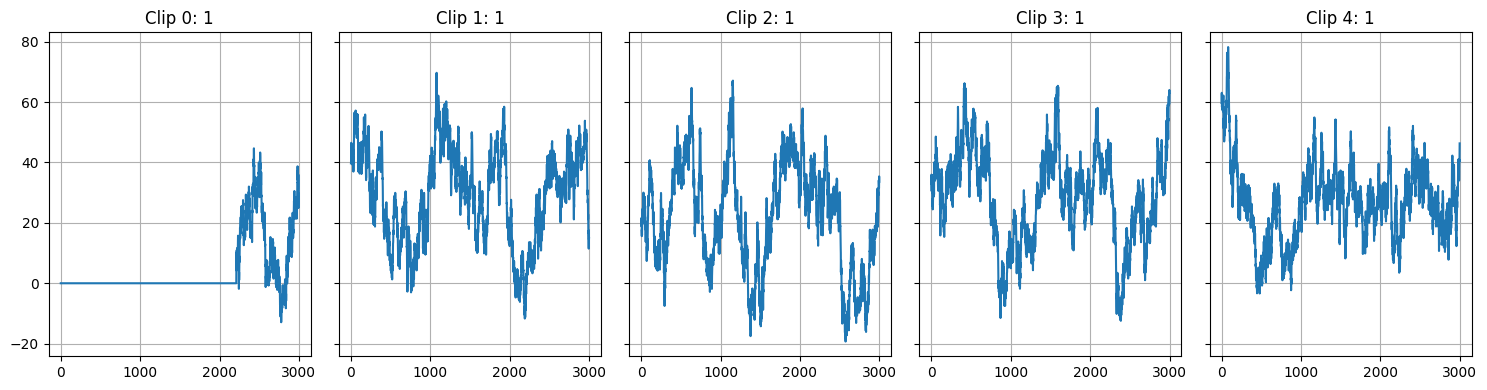

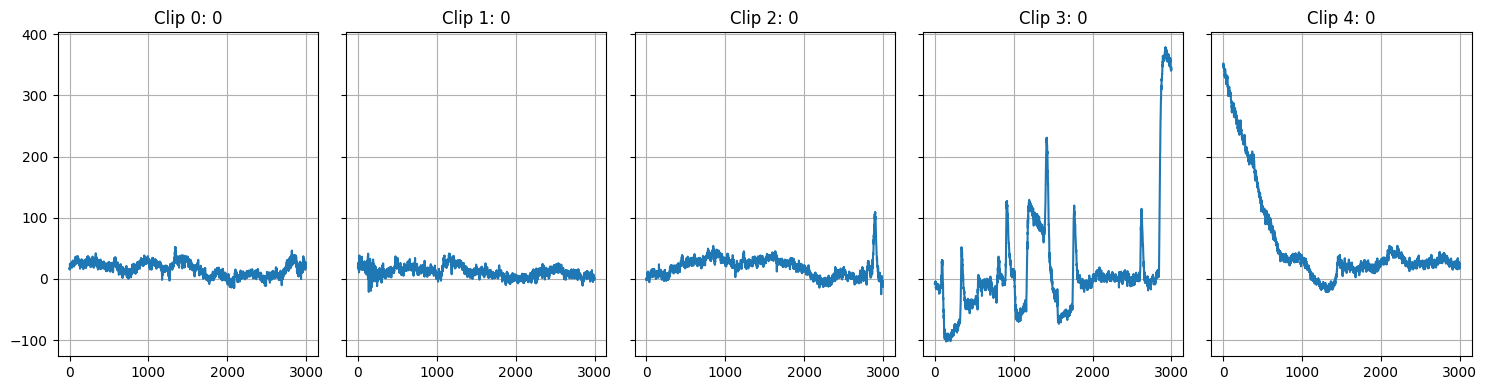

In [13]:
#plot signal label 1 and label 0
# get all signals with label 1
x_label_1 = signals[labels == 1]
# get all signals with label 0
x_label_0 = signals[labels == 0]
# plot first 5 signals with label 1
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_label_1[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 1"))
fig.tight_layout()
plt.show()
# plot first 5 signals with label 0
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5):
    axes[i].plot(x_label_0[i])
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: 0"))
fig.tight_layout()
plt.show()

In [18]:
def compute_acf_integral(x: np.ndarray, lags: int = 100, n:int = 5) -> np.ndarray:
    acf_values_integrate = []
    for i in range(x.shape[1]):
        acf_value_to_integrate = acf(x[:, i], nlags=lags)
        #integrate first n values
        acf_value_to_integrate = np.trapz(acf_value_to_integrate[:n])
        acf_values_integrate.append(acf_value_to_integrate)
    print(acf_values_integrate)
    return acf_values_integrate
lags = 10
n = 2
# get signal with label 1
x_label_1 = signals[labels == 1]
# get signal with label 0
x_label_0 = signals[labels == 0]
# compute acf integral for label 1
mean_acf_integral_label_1 = compute_acf_integral(x_label_1**2, lags=lags, n=n)
# compute acf integral for label 0
mean_acf_integral_label_0 = compute_acf_integral(x_label_0**2, lags=lags, n=n)

/var/folders/dd/nv1lky5s1851076c3xc874p80000gn/T/ipykernel_69484/4068284646.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  acf_value_to_integrate = np.trapz(acf_value_to_integrate[:n])


[np.float64(0.6228408549760006), np.float64(0.638371105345457), np.float64(0.6316949314977915), np.float64(0.6652578702884568), np.float64(0.6245801527200721), np.float64(0.6404229645138001), np.float64(0.6389407659831141), np.float64(0.6514552936882411), np.float64(0.6043281825672182), np.float64(0.5037830499579498), np.float64(0.5034622141892743), np.float64(0.5048889497001475), np.float64(0.5038584126168646), np.float64(0.5043064717059458), np.float64(0.5038675071705087), np.float64(0.5040202651762866), np.float64(0.504120877188524), np.float64(0.5036660385563009), np.float64(0.503816711712511), np.float64(0.5036801141660021), np.float64(0.5040347609603015), np.float64(0.503618741230794), np.float64(0.5036160155556042), np.float64(0.5033969342557352), np.float64(0.5038855028349035), np.float64(0.5036643348639127), np.float64(0.5034475526585352), np.float64(0.5032627890345894), np.float64(0.5037768784670907), np.float64(0.5032592418278216), np.float64(0.5032181440862935), np.float64(

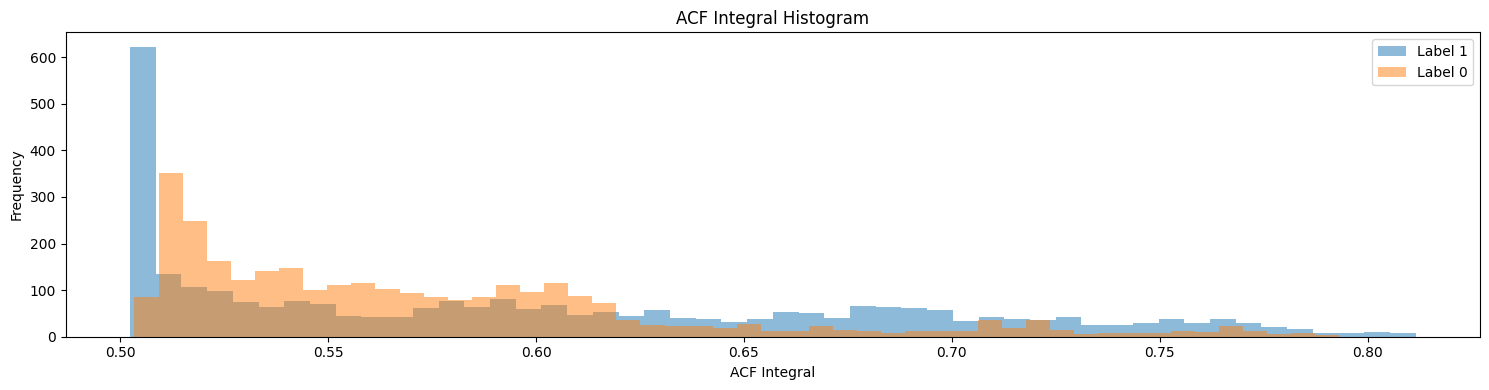

In [19]:
# plot histogram of acf integral for label 1 and label 0 in one plot
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharey=True)
axes.hist(mean_acf_integral_label_1, bins=50, alpha=0.5, label="Label 1")
axes.hist(mean_acf_integral_label_0, bins=50, alpha=0.5, label="Label 0")
axes.set(title="ACF Integral Histogram", xlabel="ACF Integral", ylabel="Frequency")
axes.legend()
fig.tight_layout()
plt.show()